# Small CNN

In [2]:
import PIL
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
import time
import os
import copy
import math
print(torch.__version__)
plt.ion()   # interactive mode

1.3.0+cpu


In [3]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize([224,224]),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize([224,224]),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [4]:
data_dir = '../numerical_examples/data/small'
CHECK_POINT_PATH = '../numerical_examples/models/checkpoint_small.tar'
CHECK_POINT_PATH_BN = '../numerical_examples/models/checkpoint_small_bn.tar'
SUBMISSION_FILE = '../numerical_examples/data/submission_small.c'
SUBMISSION_FILE_BN = '../numerical_examples/data/submission_small_bn.csv'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                              shuffle=True, num_workers=4)
              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(class_names) # => ['cats', 'dogs']
print(f'Train image size: {dataset_sizes["train"]}')
print(f'Validation image size: {dataset_sizes["val"]}')

['cats', 'dogs']
Train image size: 892
Validation image size: 302


In [5]:
from cnn_pytorch import ConvNetBN, ConvNet

In [6]:
modelBN = ConvNetBN()
print(modelBN)

ConvNetBN(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (drop_out): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=200704, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=2, bias=True)
)


In [7]:
model = ConvNet()
print(model)

ConvNet(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (drop_out): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=200704, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=2, bias=True)
)


In [8]:
model = model.to(device)
modelBN = modelBN.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
optimizerBN = torch.optim.Adam(modelBN.parameters(), lr=0.001)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
exp_lr_schedulerBN = lr_scheduler.StepLR(optimizerBN, step_size=7, gamma=0.1)
from cnn_pytorch import train_model

In [9]:
try:
    checkpoint = torch.load(CHECK_POINT_PATH)
    print("checkpoint loaded")
except:
    checkpoint = None
    print("checkpoint not found")
model, best_val_loss, best_val_acc = train_model(model,
                                                 criterion,
                                                 optimizer,
                                                 exp_lr_scheduler,
                                                 num_epochs = 5,
                                                 checkpoint = checkpoint,
                                                 dataloaders = dataloaders,
                                                 device = device,
                                                 dataset_sizes = dataset_sizes)
torch.save({'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_val_loss': best_val_loss,
            'best_val_accuracy': best_val_acc,
            'scheduler_state_dict' : exp_lr_scheduler.state_dict(),
            }, CHECK_POINT_PATH)

checkpoint not found
Epoch 0/4
----------


/home/shomed/m/martinob/Documents/host2019/VisInt/venv/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:100: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


[1, 99] loss: 3.431
[1, 199] loss: 2.055
train Loss: 1.9074 Acc: 0.5291
val Loss: 0.7024 Acc: 0.5000
New best model found!
New record loss: 0.7023756630373317, previous record loss: inf

Epoch 1/4
----------
[2, 99] loss: 0.688
[2, 199] loss: 0.691
train Loss: 0.6915 Acc: 0.5101
val Loss: 0.6937 Acc: 0.5000
New best model found!
New record loss: 0.6937001718590591, previous record loss: 0.7023756630373317

Epoch 2/4
----------
[3, 99] loss: 0.697
[3, 199] loss: 0.696
train Loss: 0.6958 Acc: 0.4955
val Loss: 0.6933 Acc: 0.5000
New best model found!
New record loss: 0.6932887841534141, previous record loss: 0.6937001718590591

Epoch 3/4
----------
[4, 99] loss: 0.694
[4, 199] loss: 0.694
train Loss: 0.6945 Acc: 0.4720
val Loss: 0.6934 Acc: 0.5000

Epoch 4/4
----------
[5, 99] loss: 0.693
[5, 199] loss: 0.695
train Loss: 0.6957 Acc: 0.4765
val Loss: 0.6933 Acc: 0.5000

Training complete in 20m 41s
Best val Acc: 0.5000 Best val loss: 0.6933


OSError: [Errno 122] Disk quota exceeded

In [ ]:
try:
    checkpoint = torch.load(CHECK_POINT_PATH_BN)
    print("checkpoint loaded")
except:
    checkpoint = None
    print("checkpoint not found")
modelBN, best_val_loss, best_val_acc = train_model(modelBN,
                                                   criterion,
                                                   optimizerBN,
                                                   exp_lr_schedulerBN,
                                                   num_epochs = 5,
                                                   checkpoint = checkpoint,
                                                   dataloaders = dataloaders,
                                                   device = device,
                                                   dataset_sizes = dataset_sizes)
torch.save({'model_state_dict': modelBN.state_dict(),
            'optimizer_state_dict': optimizerBN.state_dict(),
            'best_val_loss': best_val_loss,
            'best_val_accuracy': best_val_acc,
            'scheduler_state_dict' : exp_lr_schedulerBN.state_dict(),
            }, CHECK_POINT_PATH_BN)

In [ ]:
PredictToCSV(SUBMISSION_FILE,model)

In [ ]:
PredictToCSV(SUBMISSION_FILE_BN,modelBN)

# ResNet18 Kaggle competition cats and dogs

In [4]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(5),
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop(224, scale=(0.96, 1.0), ratio=(0.95, 1.05)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize([224,224]),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [5]:
data_dir = '../numerical_examples/data'
CHECK_POINT_PATH = '../numerical_examples/models/checkpoint.tar'
SUBMISSION_FILE = '../numerical_examples/data/submission.csv'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                              shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(class_names) # => ['cats', 'dogs']
print(f'Train image size: {dataset_sizes["train"]}')
print(f'Validation image size: {dataset_sizes["val"]}')

['cats', 'dogs']
Train image size: 23000
Validation image size: 2000


c:\users\moutz\desktop\pythonenv\venv\lib\site-packages\matplotlib\text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


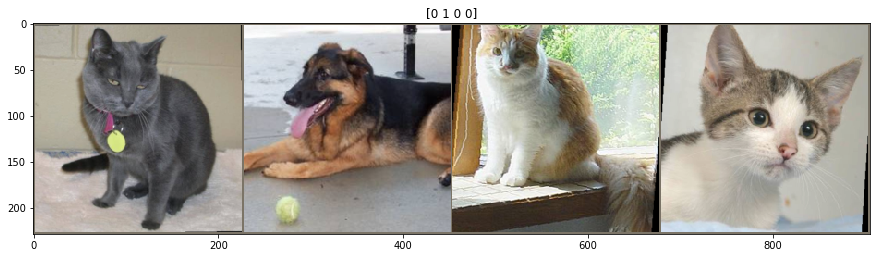

In [6]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
# Make a grid from batch
sample_train_images = torchvision.utils.make_grid(inputs)
imshow(sample_train_images, title=classes.numpy())

In [37]:

def train_model(model, criterion, optimizer, scheduler, num_epochs=2, checkpoint = None, dataloaders = None):
    since = time.time()
    if dataloaders is None:
        print("no dataloader")
        return
    
    if checkpoint is None:
        best_model_wts = copy.deepcopy(model.state_dict())
        best_loss = math.inf
        best_acc = 0.
    else:
        print(f'Val loss: {checkpoint["best_val_loss"]}, Val accuracy: {checkpoint["best_val_accuracy"]}')
        model.load_state_dict(checkpoint['model_state_dict'])
        best_model_wts = copy.deepcopy(model.state_dict())
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        best_loss = checkpoint['best_val_loss']
        best_acc = checkpoint['best_val_accuracy']

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for i, (inputs, labels) in enumerate(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()
                
                if i % 1000 == 999:
                    print('[%d, %d] loss: %.3f' % 
                          (epoch + 1, i, running_loss / (i * inputs.size(0))))

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                print(f'New best model found!')
                print(f'New record loss: {epoch_loss}, previous record loss: {best_loss}')
                best_loss = epoch_loss
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:.4f} Best val loss: {:.4f}'.format(best_acc, best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, best_loss, best_acc

In [8]:
model_conv = torchvision.models.resnet18(pretrained=True)

In [55]:
print(model_conv)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [10]:
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [12]:
checkpoint = torch.load(CHECK_POINT_PATH)
model_conv.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [32]:
try:
    checkpoint = torch.load(CHECK_POINT_PATH)
    print("checkpoint loaded")
except:
    checkpoint = None
    print("checkpoint not found")
model_conv, best_val_loss, best_val_acc = train_model(model_conv,
                                                      criterion,
                                                      optimizer_conv,
                                                      exp_lr_scheduler,
                                                      num_epochs = 3,
                                                      checkpoint = checkpoint)
torch.save({'model_state_dict': model_conv.state_dict(),
            'optimizer_state_dict': optimizer_conv.state_dict(),
            'best_val_loss': best_val_loss,
            'best_val_accuracy': best_val_acc,
            'scheduler_state_dict' : exp_lr_scheduler.state_dict(),
            }, CHECK_POINT_PATH)

checkpoint not found
Epoch 0/2
----------


c:\users\moutz\desktop\pythonenv\venv\lib\site-packages\torch\optim\lr_scheduler.py:100: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


[1, 199] loss: 0.349
[1, 399] loss: 0.366
[1, 599] loss: 0.374
[1, 799] loss: 0.376
[1, 999] loss: 0.376
[1, 1199] loss: 0.380
[1, 1399] loss: 0.377
[1, 1599] loss: 0.380
[1, 1799] loss: 0.373
[1, 1999] loss: 0.366
[1, 2199] loss: 0.374
[1, 2399] loss: 0.381
[1, 2599] loss: 0.376
[1, 2799] loss: 0.371
[1, 2999] loss: 0.374
[1, 3199] loss: 0.370
[1, 3399] loss: 0.374
[1, 3599] loss: 0.374
[1, 3799] loss: 0.379
[1, 3999] loss: 0.379
[1, 4199] loss: 0.381
[1, 4399] loss: 0.386
[1, 4599] loss: 0.383
[1, 4799] loss: 0.381
[1, 4999] loss: 0.379
[1, 5199] loss: 0.377
[1, 5399] loss: 0.377
[1, 5599] loss: 0.378
train Loss: 0.3777 Acc: 0.8648
[1, 199] loss: 0.227
[1, 399] loss: 0.219
val Loss: 0.2205 Acc: 0.9190
New best model found!
New record loss: 0.2204686402648922, previous record loss: inf
Epoch 1/2
----------
[2, 199] loss: 0.397
[2, 399] loss: 0.445
[2, 599] loss: 0.447
[2, 799] loss: 0.437
[2, 999] loss: 0.428
[2, 1199] loss: 0.420
[2, 1399] loss: 0.414
[2, 1599] loss: 0.417
[2, 1799] 

In [53]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

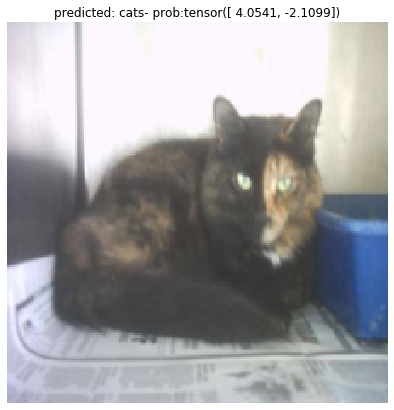

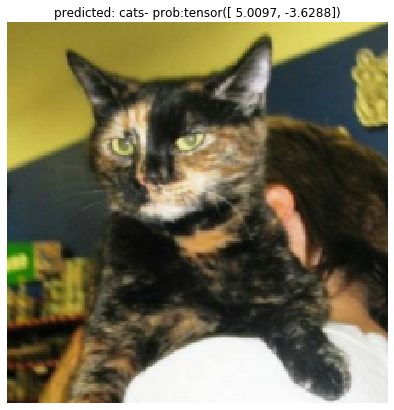

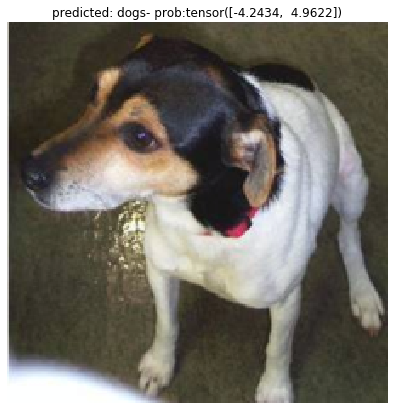

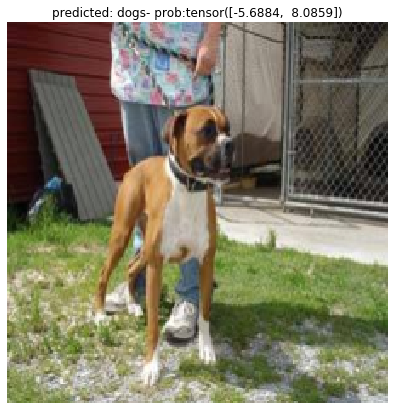

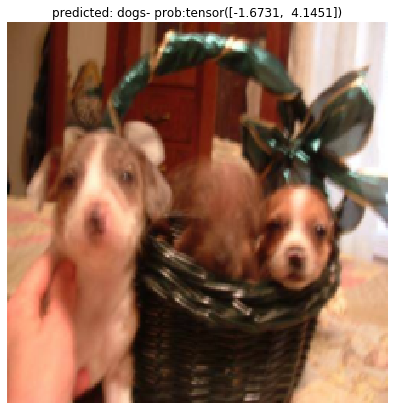

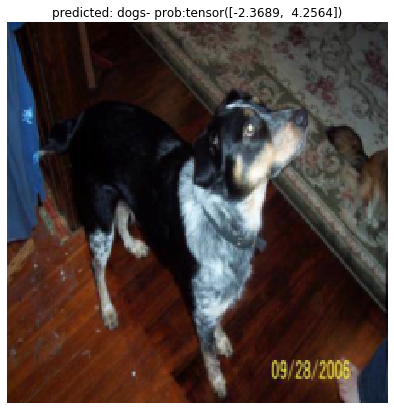

In [54]:

visualize_model(model_conv)

plt.ioff()
plt.show()

In [1]:
def apply_test_transforms(inp):
    out = transforms.functional.resize(inp, [224,224])
    out = transforms.functional.to_tensor(out)
    out = transforms.functional.normalize(out, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    return out

In [50]:
from PIL import Image

test_data_dir = f'{data_dir}/test'
test_data_files = os.listdir(test_data_dir)

In [42]:
def predict_dog_prob_of_single_instance(model, tensor):
    batch = torch.stack([tensor])
    softMax = nn.Softmax(dim = 1)
    preds = softMax(model(batch))
    return preds[0,1].item()

In [43]:
def test_data_from_fname(fname):
    im = Image.open(f'{test_data_dir}/{fname}')
    return apply_test_transforms(im)

In [44]:
def extract_file_id(fname):
    return int(re.search('\d+', fname).group())

In [ ]:
model_conv.eval() # set model to eval mode
id_to_dog_prob = {extract_file_id(fname): 
                  predict_dog_prob_of_single_instance(model_conv, test_data_from_fname(fname))
                  for fname in test_data_files}

In [ ]:
import csv
import os
def WriteDictToCSV(csv_file,csv_columns,dict_data):
    with open(csv_file, 'w') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=csv_columns)
        writer.writeheader()
        for data in dict_data:
            writer.writerow({'id': data, 'label': dict_data[data]})
    return    


In [ ]:
csv_file = "../numerical_examples/data/submission.csv"
csv_columns = ['id','label']
WriteDictToCSV(csv_file,csv_columns,id_to_dog_prob)

The modelled scored $0.11626$ which is around public ranking number $624$ with just $3$ epochs of training.

## No Agumentation

In [20]:
data_transforms_no_aug = {
    'train': transforms.Compose([
        transforms.Resize([224,224]),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize([224,224]),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [28]:
data_dir = '../numerical_examples/data'
CHECK_POINT_PATH2 = '../numerical_examples/models/checkpoint_no_aug.tar'
SUBMISSION_FILE = '../numerical_examples/data/submission.csv'
image_datasets_no_aug = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms_no_aug[x])
                  for x in ['train', 'val']}
dataloaders_no_aug = {x: torch.utils.data.DataLoader(image_datasets_no_aug[x], batch_size=4,
                                              shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes_no_aug = {x: len(image_datasets_no_aug[x]) for x in ['train', 'val']}
class_names = image_datasets_no_aug['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(class_names) # => ['cats', 'dogs']
print(f'Train image size: {dataset_sizes_no_aug["train"]}')
print(f'Validation image size: {dataset_sizes_no_aug["val"]}')

['cats', 'dogs']
Train image size: 23000
Validation image size: 2000


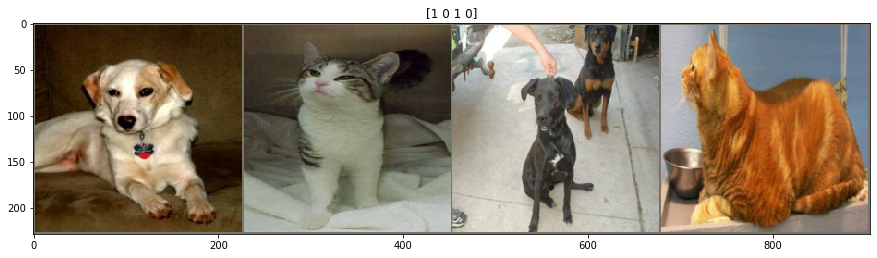

In [29]:
inputs, classes = next(iter(dataloaders_no_aug['train']))
# Make a grid from batch
sample_train_images_no_aug = torchvision.utils.make_grid(inputs)
imshow(sample_train_images_no_aug, title=classes.numpy())

In [30]:
model_conv_no_aug = torchvision.models.resnet18(pretrained=True)

In [31]:
print(model_conv_no_aug)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [32]:
for param in model_conv_no_aug.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv_no_aug.fc.in_features
model_conv_no_aug.fc = nn.Linear(num_ftrs, 2)

model_conv_no_aug = model_conv_no_aug.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized
optimizer_conv_no_aug = optim.SGD(model_conv_no_aug.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv_no_aug, step_size=7, gamma=0.1)

In [38]:
try:
    checkpoint = torch.load(CHECK_POINT_PATH2)
    print("checkpoint loaded")
except:
    checkpoint = None
    print("checkpoint not found")
model_conv_no_aug, best_val_loss, best_val_acc = train_model(model_conv_no_aug,
                                                            criterion,
                                                            optimizer_conv_no_aug,
                                                            exp_lr_scheduler,
                                                            num_epochs = 3,
                                                            checkpoint = checkpoint,
                                                            dataloaders = dataloaders_no_aug)
torch.save({'model_state_dict': model_conv_no_aug.state_dict(),
            'optimizer_state_dict': optimizer_conv_no_aug.state_dict(),
            'best_val_loss': best_val_loss,
            'best_val_accuracy': best_val_acc,
            'scheduler_state_dict' : exp_lr_scheduler.state_dict(),
            }, CHECK_POINT_PATH2)

checkpoint not found
Epoch 0/2
----------
[1, 199] loss: 0.375
[1, 399] loss: 0.399
[1, 599] loss: 0.410
[1, 799] loss: 0.434
[1, 999] loss: 0.431
[1, 1199] loss: 0.420
[1, 1399] loss: 0.408
[1, 1599] loss: 0.402
[1, 1799] loss: 0.397
[1, 1999] loss: 0.404
[1, 2199] loss: 0.397
[1, 2399] loss: 0.398
[1, 2599] loss: 0.408
[1, 2799] loss: 0.399
[1, 2999] loss: 0.394
[1, 3199] loss: 0.396
[1, 3399] loss: 0.400
[1, 3599] loss: 0.400
[1, 3799] loss: 0.400
[1, 3999] loss: 0.407
[1, 4199] loss: 0.403
[1, 4399] loss: 0.406
[1, 4599] loss: 0.411
[1, 4799] loss: 0.407
[1, 4999] loss: 0.405
[1, 5199] loss: 0.407
[1, 5399] loss: 0.408
[1, 5599] loss: 0.407
train Loss: 0.4044 Acc: 0.8599
[1, 199] loss: 0.086
[1, 399] loss: 0.087
val Loss: 0.0920 Acc: 0.9640
New best model found!
New record loss: 0.0919591407828848, previous record loss: inf

Epoch 1/2
----------
[2, 199] loss: 0.405
[2, 399] loss: 0.363
[2, 599] loss: 0.365
[2, 799] loss: 0.352
[2, 999] loss: 0.347
[2, 1199] loss: 0.352
[2, 1399] l

In [ ]:
import re
id_to_dog_prob_no_aug = {extract_file_id(fname): 
                  predict_dog_prob_of_single_instance(model_conv_no_aug, test_data_from_fname(fname))
                  for fname in test_data_files}

In [ ]:
csv_file = "../numerical_examples/data/submission_no_aug.csv"
csv_columns = ['id','label']
WriteDictToCSV(csv_file,csv_columns,id_to_dog_prob_no_aug)

# Transfer Learning VGG18 with batch normalization

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
keras = tf.keras
import tensorflow_datasets as tfds

In [3]:
SPLIT_WEIGHTS = (5, 1, 4)
splits = tfds.Split.TRAIN.subsplit(weighted=SPLIT_WEIGHTS)

(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'cats_vs_dogs', split=list(splits),
    with_info=True, as_supervised=True)

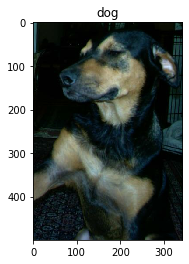

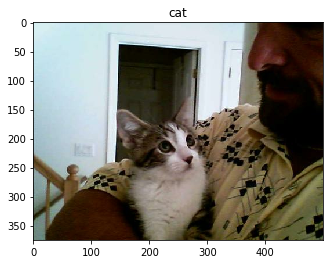

In [4]:
get_label_name = metadata.features['label'].int2str

for image, label in raw_train.take(2):
    plt.figure()
    plt.imshow(image)
    plt.title(get_label_name(label))

In [5]:
IMG_SIZE = 160 # All images will be resized to 160x160

def format_example(image, label):
    image = tf.cast(image, tf.float32)
    image = (image/127.5) - 1
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

In [6]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

In [7]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

In [8]:
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [9]:
for image_batch, label_batch in train_batches.take(1):
    pass

In [10]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                         include_top=False,
                                         weights='imagenet')

In [11]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D
from tensorflow.keras.layers import BatchNormalization, Activation, Dropout

def conv_block(units, dropout=0.2, activation='relu', block=1, layer=1, batch_norm = True):

    def layer_wrapper(inp, batch_norm = batch_norm):
        x = Conv2D(units, (3, 3), padding='same', name='block{}_conv{}'.format(block, layer))(inp)
        if batch_norm:
            x = BatchNormalization(name='block{}_bn{}'.format(block, layer))(x)
        x = Activation(activation, name='block{}_act{}'.format(block, layer))(x)
        return x

    return layer_wrapper


def dense_block(units, dropout=0.2, activation='relu', name='fc1', batch_norm = True):

    def layer_wrapper(inp, batch_norm = batch_norm):
        x = Dense(units, name=name)(inp)
        if batch_norm:
            x = BatchNormalization(name='{}_bn'.format(name))(x)
        x = Activation(activation, name='{}_act'.format(name))(x)
        return x

    return layer_wrapper


In [12]:
def VGG16(input_shape=None, classes=1000, conv_dropout=0.1, dropout=0.3, activation='relu', batch_norm = True):
    img_input =Input(shape=input_shape) 
    # Block 1
    x = conv_block(64, dropout=conv_dropout, activation=activation, block=1, layer=1, batch_norm = batch_norm)(img_input)
    x = conv_block(64, dropout=conv_dropout, activation=activation, block=1, layer=2, batch_norm = batch_norm)(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = conv_block(128, dropout=conv_dropout, activation=activation, block=2, layer=1, batch_norm = batch_norm)(x)
    x = conv_block(128, dropout=conv_dropout, activation=activation, block=2, layer=2, batch_norm = batch_norm)(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Block 3
    x = conv_block(256, dropout=conv_dropout, activation=activation, block=3, layer=1, batch_norm = batch_norm)(x)
    x = conv_block(256, dropout=conv_dropout, activation=activation, block=3, layer=2, batch_norm = batch_norm)(x)
    x = conv_block(256, dropout=conv_dropout, activation=activation, block=3, layer=3, batch_norm = batch_norm)(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    # Block 4
    x = conv_block(512, dropout=conv_dropout, activation=activation, block=4, layer=1, batch_norm = batch_norm)(x)
    x = conv_block(512, dropout=conv_dropout, activation=activation, block=4, layer=2, batch_norm = batch_norm)(x)
    x = conv_block(512, dropout=conv_dropout, activation=activation, block=4, layer=3, batch_norm = batch_norm)(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    # Block 5
    x = conv_block(512, dropout=conv_dropout, activation=activation, block=5, layer=1, batch_norm = batch_norm)(x)
    x = conv_block(512, dropout=conv_dropout, activation=activation, block=5, layer=2, batch_norm = batch_norm)(x)
    x = conv_block(512, dropout=conv_dropout, activation=activation, block=5, layer=3, batch_norm = batch_norm)(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)

    # Flatten
    x = GlobalAveragePooling2D()(x)

    # FC Layers
    x = dense_block(512, dropout=dropout, activation=activation, name='fc1', batch_norm = batch_norm)(x)
    x = dense_block(512, dropout=dropout, activation=activation, name='fc2', batch_norm = batch_norm)(x)
    
    # Classification block    
    x = Dense(classes, activation='softmax', name='predictions')(x)

    # Ensure that the model takes into account any potential predecessors of `input_tensor`.
    inputs = img_input
    name_str = ("vgg16" if not batch_norm else ("vgg16_bn"))
    # Create model.
    return Model(inputs, x, name=name_str)

In [18]:
model1 = VGG16(input_shape = (160,160,3),classes = 1, batch_norm = True)
model1.summary()

Model: "vgg16_bn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 160, 160, 64)      1792      
_________________________________________________________________
block1_bn1 (BatchNormalizati (None, 160, 160, 64)      256       
_________________________________________________________________
block1_act1 (Activation)     (None, 160, 160, 64)      0         
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 160, 160, 64)      36928     
_________________________________________________________________
block1_bn2 (BatchNormalizati (None, 160, 160, 64)      256       
_________________________________________________________________
block1_act2 (Activation)     (None, 160, 160, 64)      0  

In [19]:
model2 = VGG16(input_shape = (160,160,3),classes = 1, batch_norm = False)
model2.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 160, 160, 64)      1792      
_________________________________________________________________
block1_act1 (Activation)     (None, 160, 160, 64)      0         
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 160, 160, 64)      36928     
_________________________________________________________________
block1_act2 (Activation)     (None, 160, 160, 64)      0         
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 80, 80, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 80, 80, 128)       73856 

In [20]:
base_model.save_weights("tmp.h5")
model1.load_weights("tmp.h5",by_name=True)
model2.load_weights("tmp.h5",by_name=True)

In [21]:
num_train, num_val, num_test = (
  metadata.splits['train'].num_examples*weight/10
  for weight in SPLIT_WEIGHTS
)

In [22]:
initial_epochs = 10
steps_per_epoch = round(num_train)//BATCH_SIZE
validation_steps = 20


In [ ]:
loss0,accuracy0 = model1.evaluate(validation_batches, steps = validation_steps)

In [24]:
loss0,accuracy0 = model2.evaluate(validation_batches, steps = validation_steps)

20/20 [==============================] - ETA: 1:04 - loss: 9.1041 - accuracy: 0.40 - ETA: 58s - loss: 8.3854 - accuracy: 0.4531 - ETA: 54s - loss: 8.7847 - accuracy: 0.427 - ETA: 50s - loss: 8.5052 - accuracy: 0.445 - ETA: 46s - loss: 8.3374 - accuracy: 0.456 - ETA: 43s - loss: 8.0659 - accuracy: 0.474 - ETA: 40s - loss: 7.9404 - accuracy: 0.482 - ETA: 37s - loss: 7.6067 - accuracy: 0.503 - ETA: 34s - loss: 7.5069 - accuracy: 0.510 - ETA: 31s - loss: 7.5708 - accuracy: 0.506 - ETA: 28s - loss: 7.4924 - accuracy: 0.511 - ETA: 25s - loss: 7.7465 - accuracy: 0.494 - ETA: 22s - loss: 7.8141 - accuracy: 0.490 - ETA: 19s - loss: 7.8035 - accuracy: 0.491 - ETA: 16s - loss: 7.7305 - accuracy: 0.495 - ETA: 13s - loss: 7.8164 - accuracy: 0.490 - ETA: 10s - loss: 7.8639 - accuracy: 0.487 - ETA: 6s - loss: 7.8530 - accuracy: 0.487 - ETA: 3s - loss: 7.8684 - accuracy: 0.48 - 68s 3s/step - loss: 7.8583 - accuracy: 0.4875


In [23]:
loss_object = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam()
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Accuracy(name='train_accuracy')

validation_loss = tf.keras.metrics.Mean(name='validation_loss')
validation_accuracy = tf.keras.metrics.Accuracy(name='validation_accuracy')

In [24]:
@tf.function
def train_step(images, labels,model):
    with tf.GradientTape() as tape:
        predictions = model(images)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_accuracy(labels, predictions)
    
@tf.function
def validation_step(images, labels,model):
    predictions = model(images)
    v_loss = loss_object(labels, predictions)

    validation_loss(v_loss)
    validation_accuracy(labels, predictions)

In [ ]:
EPOCHS = 5

for epoch in range(EPOCHS):
    i_train = 0
    for image, label in train_batches:
        template_train = 'Training steps {}/{}'
        print(template_train.format(i_train, steps_per_epoch),end="\r")
        train_step(image, label,model1)
        i_train += 1
        if i_train == steps_per_epoch:
            break
    for image, label in validation_batches:
        validation_step(image, label,model1)

    template = 'Epoch {}, Loss: {}, Accuracy: {}, Validation Loss: {}, Validation Accuracy: {}'
    print(template.format(epoch+1,
                        train_loss.result(),
                        train_accuracy.result()*100,
                        validation_loss.result(),
                        validation_accuracy.result()*100))

    # Reset the metrics for the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    validation_loss.reset_states()
    validation_accuracy.reset_states()

Epoch 1, Loss: 7.621739387512207, Accuracy: 50.292701721191406, Validation Loss: 7.8372802734375, Validation Accuracy: 48.88412094116211
Epoch 2, Loss: 7.613818168640137, Accuracy: 50.34435272216797, Validation Loss: 7.8372802734375, Validation Accuracy: 48.88412094116211
Epoch 3, Loss: 7.617777347564697, Accuracy: 50.31852722167969, Validation Loss: 7.8372802734375, Validation Accuracy: 48.88412094116211


In [ ]:
EPOCHS = 5

for epoch in range(EPOCHS):
    i_train = 0
    for image, label in train_batches:
        template_train = 'Training steps {}/{}'
        print(template_train.format(i_train, steps_per_epoch),end="\r")
        train_step(image, label,model2)
        i_train += 1
        if i_train == steps_per_epoch:
            break
    for image, label in validation_batches:
        validation_step(image, label,model2)

    template = 'Epoch {}, Loss: {}, Accuracy: {}, Validation Loss: {}, Validation Accuracy: {}'
    print(template.format(epoch+1,
                        train_loss.result(),
                        train_accuracy.result()*100,
                        validation_loss.result(),
                        validation_accuracy.result()*100))

    # Reset the metrics for the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    validation_loss.reset_states()
    validation_accuracy.reset_states()